In [2]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

# 벡터 임베딩 분석

In [3]:
data_path = "../../data/"

train_df = pd.read_csv(os.path.join(data_path, "train_eda.csv"))

In [4]:
bins = [0.0, 0.3, 0.6, 1.0]
labels = ['low', 'mid', 'high']
train_df['coverage_bin'] = pd.cut(train_df['coverage_ratio'], bins=bins, labels=labels)

In [5]:

with open("../../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

print(config["tokenizer"]["special_tokens"])

['#Address#', '#Alex#', '#Bob#', '#CardNumber#', '#CarNumber#', '#DateOfBirth#', '#Email#', '#Kristin#', '#Liliana#', '#Name#', '#PassportNumber#', '#Person1#', '#Person2#', '#Person3#', '#Person4#', '#Person5#', '#Person6#', '#Person7#', '#PersonName#', '#PhoneNumber#', '#Price#', '#SSN#']


In [6]:
from transformers import BartTokenizer, BartModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

special_tokens_dict = {
  "additional_special_tokens": config["tokenizer"]["special_tokens"]
}

tokenizer.add_special_tokens(special_tokens_dict)

model = BartModel.from_pretrained("facebook/bart-base")
model.resize_token_embeddings(len(tokenizer))
model.to(device)
model.eval()


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BartModel(
  (shared): Embedding(50287, 768)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(50287, 768)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
    (layers): ModuleList(
      (0-5): 6 x BartEncoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layernorm_embedding): LayerNorm((768,), eps=1e-05, ele

In [ ]:
def get_bart_embeddings_batch(texts, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # [B, H]
            all_embeddings.extend(embeddings.cpu())  # 개별 tensor 저장
    return all_embeddings # [CLS] 유사 mean pooling

In [8]:
def get_bin_embeddings(bin, df):
    df_bin = df[df["coverage_bin"] == bin]
    texts = df_bin["dialogue"].tolist()
    embeddings = get_bart_embeddings_batch(texts, batch_size=32)
    return embeddings

In [9]:
high_embeddings = get_bin_embeddings("high", train_df)
mid_embeddings = get_bin_embeddings("mid", train_df)
low_embeddings = get_bin_embeddings("low", train_df)

Embedding batches: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


In [28]:
import umap.umap_ as umap
import hdbscan

def plot_dbscan_clusters(embeddings, title, min_cluster_size=30):
  X = np.stack([emb.numpy() if hasattr(emb, "numpy") else emb for emb in embeddings])

  # 1. UMAP 차원 축소
  X_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42).fit_transform(X)

  X_umap = (X_umap - X_umap.min(0)) / (X_umap.max(0) - X_umap.min(0))

  # 2. HDBSCAN 클러스터링
  clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit(X_umap)
  labels = clusterer.labels_  # -1: 노이즈

  # 3. 시각화
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8,6))
  plt.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap='Spectral', s=10)
  plt.title(f"{title} UMAP + HDBSCAN Clustering")
  plt.colorbar()
  plt.show()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


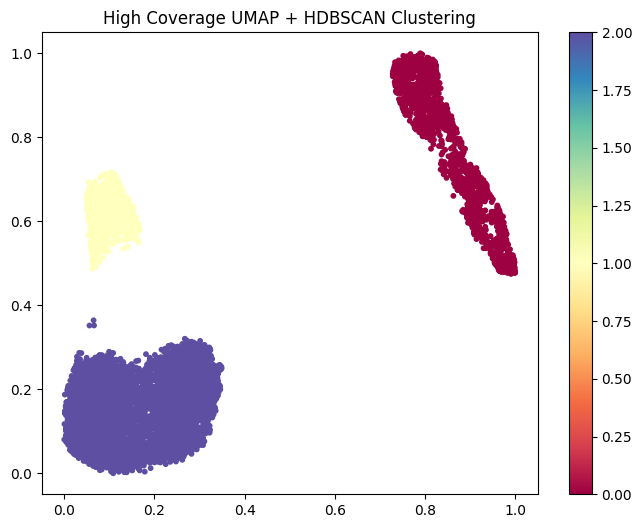

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


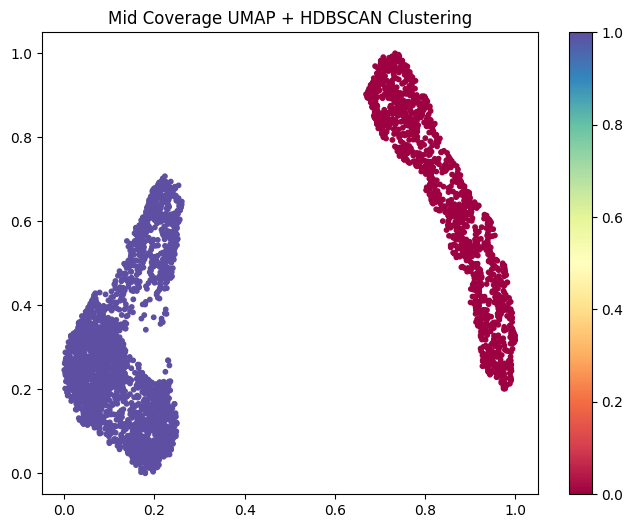

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


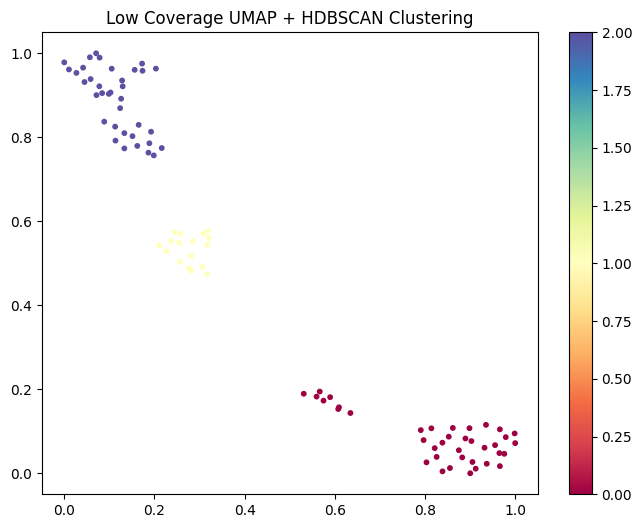

In [30]:
plot_dbscan_clusters(high_embeddings, "High Coverage")
plot_dbscan_clusters(mid_embeddings, "Mid Coverage")
plot_dbscan_clusters(low_embeddings, "Low Coverage", 10)

In [25]:
def get_bin_embeddings_summary(bin, df):
    df_bin = df[df["coverage_bin"] == bin]
    texts = df_bin["summary"].tolist()
    embeddings = get_bart_embeddings_batch(texts, batch_size=32)
    return embeddings

In [ ]:
high_embeddings_summary = get_bin_embeddings_summary("high", train_df)
mid_embeddings_summary = get_bin_embeddings_summary("mid", train_df)
low_embeddings_summary = get_bin_embeddings_summary("low", train_df)

Embedding batches: 100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


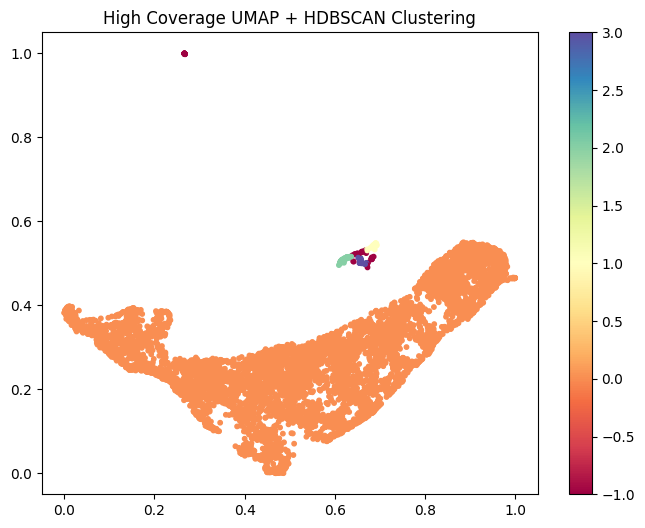

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


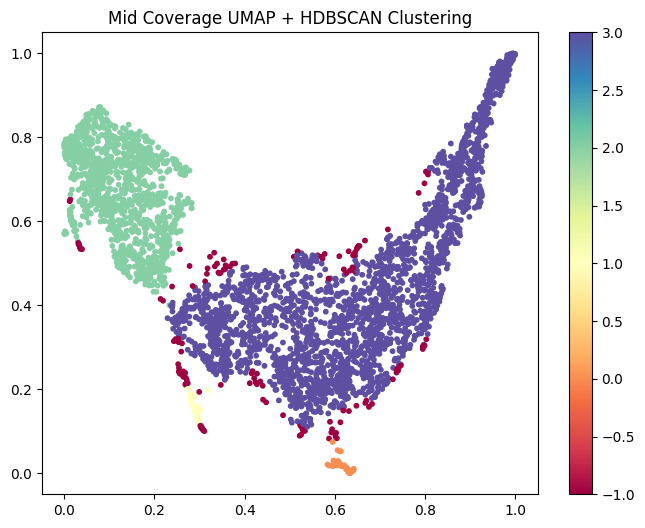

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


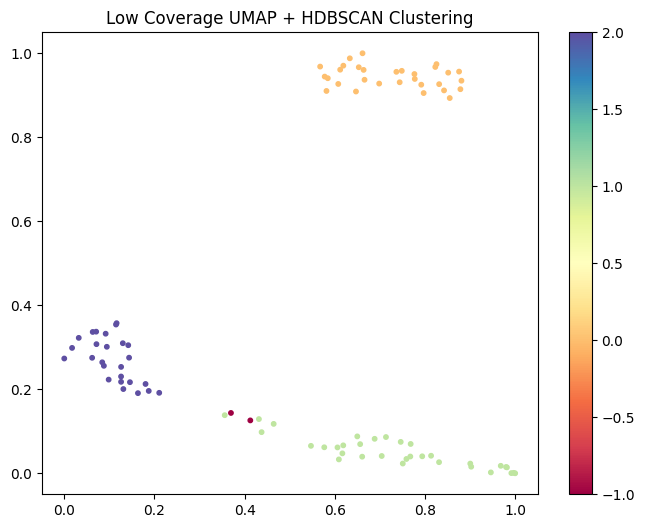

In [32]:
plot_dbscan_clusters(high_embeddings_summary, "High Coverage")
plot_dbscan_clusters(mid_embeddings_summary, "Mid Coverage")
plot_dbscan_clusters(low_embeddings_summary, "Low Coverage", 10)

## HIGH 그룹 원문 요약문 확인

In [33]:
n = 15
print(f"-----------------------------------{n}개 데이터-----------------------------------")
for i in range(n):
  print(f"원문[{i}] {train_df[train_df['coverage_bin'] == 'high'].iloc[i]['dialogue']}")
  print(f"요약문[{i}] {train_df[train_df['coverage_bin'] == 'high'].iloc[i]['summary']}")
  print(f"커버리지 비율[{i}] {train_df[train_df['coverage_bin'] == 'high'].iloc[i]['coverage_ratio']}")
  print(f"비커버리지 비율[{i}] {train_df[train_df['coverage_bin'] == 'high'].iloc[i]['noncoverage_ratio']}")
  print("-"*100)

-----------------------------------15개 데이터-----------------------------------
원문[0] #Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다. 오늘 무슨 일로 오셨어요? 
#Person2#: 건강검진을 받으려고 왔어요. 
#Person1#: 네, 5년 동안 검진을 안 받으셨네요. 매년 한 번씩 받으셔야 해요. 
#Person2#: 알죠. 특별히 아픈 데가 없으면 굳이 갈 필요가 없다고 생각했어요. 
#Person1#: 음, 심각한 질병을 피하려면 미리 발견하는 게 제일 좋거든요. 본인을 위해서라도 매년 한 번은 오세요. 
#Person2#: 알겠습니다. 
#Person1#: 여기 좀 볼까요. 눈과 귀는 괜찮으시네요. 깊게 숨 한 번 쉬어보세요. Mr. Smith, 담배 피우세요? 
#Person2#: 네. 
#Person1#: 담배가 폐암하고 심장병의 주된 원인인 거 아시죠? 끊으셔야 해요. 
#Person2#: 수백 번 시도했는데, 도저히 습관이 안 끊어져요. 
#Person1#: 음, 도움 될만한 수업과 약물들이 있습니다. 가시기 전에 더 정보를 드릴게요. 
#Person2#: 네, 고맙습니다, 의사 선생님.
요약문[0] Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필요성을 안내받고 흡연 습관 개선을 위한 도움을 제안받았습니다.
커버리지 비율[0] 0.7
비커버리지 비율[0] 0.3
----------------------------------------------------------------------------------------------------
원문[1] #Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?
#Person2#: 안녕하세요, Dr. Peters. 잘 지내고 있어요. Ricky랑 저희 둘 다 백신 맞으러 왔어요.
#Person1#: 알겠습니다. 백신 기록을 보니 Ricky는 소아마비,

## Mid 그룹 원문 요약문 확인

In [34]:
n = 15
print(f"-----------------------------------{n}개 데이터-----------------------------------")
for i in range(n):
  print(f"원문[{i}] {train_df[train_df['coverage_bin'] == 'mid'].iloc[i]['dialogue']}")
  print(f"요약문[{i}] {train_df[train_df['coverage_bin'] == 'mid'].iloc[i]['summary']}")
  print(f"커버리지 비율[{i}] {train_df[train_df['coverage_bin'] == 'mid'].iloc[i]['coverage_ratio']}")
  print(f"비커버리지 비율[{i}] {train_df[train_df['coverage_bin'] == 'mid'].iloc[i]['noncoverage_ratio']}")
  print("-"*100)

-----------------------------------15개 데이터-----------------------------------
원문[0] #Person1#: 저기요, 열쇠 세트 본 적 있어요?
#Person2#: 어떤 종류의 열쇠요?
#Person1#: 열쇠 다섯 개랑 작은 발 장식이 달려 있어요.
#Person2#: 아, 안타깝네요! 못 봤어요.
#Person1#: 그럼, 같이 좀 찾아주실 수 있어요? 여긴 처음이라서요.
#Person2#: 물론이죠. 도와드릴게요.
#Person1#: 정말 친절하시네요.
#Person2#: 별거 아니에요. 이봐요, 찾았어요.
#Person1#: 아, 감사합니다! 어떻게 감사해야 할지 모르겠네요.
#Person2#: 천만에요.
요약문[0] #Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라고 요청합니다.
커버리지 비율[0] 0.5833333333333334
비커버리지 비율[0] 0.4166666666666667
----------------------------------------------------------------------------------------------------
원문[1] #Person1#: 너 여자친구 있는 거 왜 말 안 했어?
#Person2#: 미안해, 네가 알고 있는 줄 알았어.
#Person1#: 그런데 사랑하는 사람 있다고 말했어야지.
#Person2#: 내가 안 했었나?
#Person1#: 안 했잖아.
#Person2#: 이제 말하잖아.
#Person1#: 맞아, 그런데 이전에 말할 수도 있었잖아.
#Person2#: 네가 관심 없을 줄 알았어.
#Person1#: 진심이야? 결혼할 거라는 말도 안 하다니 참.
#Person2#: 미안해, 별로 중요하지 않다고 생각했어.
#Person1#: 아, 남자들 다 똑같아!
요약문[1] #Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말하지 않아서 화가 났습니다.
커버리지

## Low 그룹 원문 요약문 확인

In [35]:
n = 15
print(f"-----------------------------------{n}개 데이터-----------------------------------")
for i in range(n):
  print(f"원문[{i}] {train_df[train_df['coverage_bin'] == 'low'].iloc[i]['dialogue']}")
  print(f"요약문[{i}] {train_df[train_df['coverage_bin'] == 'low'].iloc[i]['summary']}")
  print(f"커버리지 비율[{i}] {train_df[train_df['coverage_bin'] == 'low'].iloc[i]['coverage_ratio']}")
  print(f"비커버리지 비율[{i}] {train_df[train_df['coverage_bin'] == 'low'].iloc[i]['noncoverage_ratio']}")
  print("-"*100)

-----------------------------------15개 데이터-----------------------------------
원문[0] #Person1#: 그러니까 우리가 해야 할 일은 제시간에 끝내는 거야. 
#Person2#: 미안해요, 톰. 방금 말씀하신 부분 다시 말씀해 주시겠어요? 우리가 그 부분을 못 들었어요. 
#Person1#: 아, 알겠어요. 제가 말한 건 제시간에 끝내야 한다는 거예요. 
#Person2#: 미안해요, 톰. 저희 쪽에서 듣기 어렵네요. 좀 많이 끊기는데요. 저희 말 들리세요? 
#Person1#: 여보세요? 
#Person2#: 여보세요? 
#Person1#: 제 말 들리세요? 아마도 잘 안 들리겠죠. 여보세요? 저희 말 안 들리시나 봐요. 
#Person2#: 톰, 제 말 들리시면요, 연결이 끊어진 것 같네요. 문제가 있는 것 같아요. 다시 시도해볼게요. 저희가 전화하겠습니다. 
#Person1#: 네, 알겠습니다. 기다리고 있을게요.
요약문[0] Tom은 #Person2#에게 일정 내에 업무를 완료하라고 지시하지만, 전화 연결 문제로 소통에 어려움을 겪습니다.
커버리지 비율[0] 0.2666666666666666
비커버리지 비율[0] 0.7333333333333333
----------------------------------------------------------------------------------------------------
원문[1] #Person1#: 솔로몬 백화점입니다. 무엇을 도와드릴까요? 
#Person2#: 네, 오늘 몇 시에 문을 닫는지 알 수 있을까요? 
#Person1#: 저희는 오후 7시에 문을 닫습니다. 
#Person2#: 아, 그렇군요. 그럼 몇 시에 여나요? 
#Person1#: 주말에는 오전 10시에 엽니다. 
#Person2#: 알겠습니다. 감사합니다.
요약문[1] #Person2#가 #Person1#에게 매장의 영업 종료 및 개시 시간을 문의합니다.
커버리지 

## 커버리지 비율에 따른 요약 스타일 차이

| 구분           | High Coverage              | Low Coverage                   |
| ------------ | -------------------------- | ------------------------------ |
| **요약 스타일**   | **발화 복사형 (extractive 성향)** | **상황/의도 설명형 (abstractive 성향)** |
| **단어 출처**    | 원문에서 직접 인용된 단어 비율 높음       | 요약에만 등장하는 새로운 단어 많음            |
| **정보 구성**    | 명시적 정보 중심                  | 암묵적 정보 해석 및 생성                 |
| **예시 문장**    | "김 부장은 3시에 도착한다고 했어요."     | "김 부장이 늦게 올 예정임을 전달함."         |
| **의미 해석**    | 직접적 인용                     | 간접적 요약, 재구성                    |
| **모델 학습 영향** | 복사 기반 모델이 더 잘 작동           | 생성 능력이 중요한 구조 (BART, T5 등)     |


📌 1. coverage-based curriculum learning (학습 난이도 조절)
🧠 핵심 아이디어
coverage가 높은 요약은 “복사 위주”로 상대적으로 학습 난이도 낮음

coverage가 낮은 요약은 “생성 위주”로 어려움

✅ 방법
학습 초기에 high coverage 샘플 위주로 학습

이후 점진적으로 low coverage 샘플을 증가

```
# Epoch 1~3: coverage > 0.6
# Epoch 4~6: coverage > 0.3
# Epoch 7~ : full dataset
```
🚀 기대 효과
모델이 먼저 "복사하는 법"을 배우고 → 나중에 "생성하는 법"을 학습

일반화 향상 + 안정적인 학습 가능

📌 2. coverage ratio regression (보조 학습 태스크)
🧠 핵심 아이디어
요약문을 생성하면서 동시에 coverage ratio를 예측하게 함

✅ 방법
모델의 마지막 임베딩을 통해 coverage_pred = Linear(hidden)으로 예측

실제 coverage와 MSE loss로 비교 → 총 loss에 가중치 포함

python
복사
편집
loss = gen_loss + λ * mse(coverage_pred, coverage_true)
🚀 기대 효과
모델이 원문과 요약 간의 관계를 정량적으로 이해

추론 시 coverage를 제어하거나 평가에도 활용 가능

📌 3. coverage-aware data augmentation
✅ 예
coverage 높은 샘플에서 일부 단어 삭제 → 중간 coverage 샘플 생성

coverage 낮은 샘플에 원문 키워드 삽입 → 다양한 스타일로 학습 가능

